### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [215]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [216]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r', encoding = 'UTF-8') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [217]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
print("OK!")

OK!


### Data loading: "Евгений Онегин"


In [218]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding = 'UTF-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [219]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
text = text[TEXT_START:TEXT_END]

Put all the characters, that you've seen in the text, into variable `tokens`.

In [220]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [221]:
# dict <index>:<char>
# Your great code here
def get_tokens(text):
    token_to_idx = {token: idx for idx, token in enumerate(tokens)}
    print(len(token_to_idx), token_to_idx)
    
    idx_to_token = {idx: token for idx, token in enumerate(tokens)}
    print(len(idx_to_token), idx_to_token)

    return [token_to_idx[char] for char in text], token_to_idx, idx_to_token

text, token_to_idx, idx_to_token = get_tokens(text)
# dict <char>:<index>
# Your great code here

83 {'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '5': 8, '7': 9, '8': 10, '9': 11, ':': 12, ';': 13, '?': 14, '[': 15, ']': 16, '^': 17, 'a': 18, 'b': 19, 'c': 20, 'd': 21, 'e': 22, 'f': 23, 'g': 24, 'h': 25, 'i': 26, 'k': 27, 'l': 28, 'm': 29, 'n': 30, 'o': 31, 'p': 32, 'q': 33, 'r': 34, 's': 35, 't': 36, 'u': 37, 'v': 38, 'w': 39, 'x': 40, 'y': 41, 'z': 42, '«': 43, '»': 44, 'а': 45, 'б': 46, 'в': 47, 'г': 48, 'д': 49, 'е': 50, 'ж': 51, 'з': 52, 'и': 53, 'й': 54, 'к': 55, 'л': 56, 'м': 57, 'н': 58, 'о': 59, 'п': 60, 'р': 61, 'с': 62, 'т': 63, 'у': 64, 'ф': 65, 'х': 66, 'ц': 67, 'ч': 68, 'ш': 69, 'щ': 70, 'ъ': 71, 'ы': 72, 'ь': 73, 'э': 74, 'ю': 75, 'я': 76, 'ё': 77, '–': 78, '—': 79, '’': 80, '…': 81, '€': 82}
83 {0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: ',', 6: '-', 7: '.', 8: '5', 9: '7', 10: '8', 11: '9', 12: ':', 13: ';', 14: '?', 15: '[', 16: ']', 17: '^', 18: 'a', 19: 'b', 20: 'c', 21: 'd', 22: 'e', 23: 'f', 24: 'g', 25: 'h', 26: 'i', 27: 'k', 28: 'l', 29

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [222]:
# Your code here
# Список используемой литературы: https://www.geeksforgeeks.org/implementing-recurrent-neural-networks-in-pytorch/

import torch.nn as nn
import torch
import datetime

def create_batches(text, seq = 64, size = 100):
    inps_arr = []
    tars_arr = []
    
    for i in range((len(text) - seq + size - 1) // size):
        inps = []
        tars = []
        
        for j in range(i * size, min((i + 1) * size, len(text) - seq)):
            inps.append(text[j:j + seq])
            tars.append(text[j + 1:j + seq + 1])

        inps_arr.append(torch.tensor(inps, dtype = torch.int64))
        tars_arr.append(torch.tensor(tars, dtype  =torch.int64))
        
    return inps_arr, tars_arr

def train(model, dataset, size = 64, epochs = 10, learning_rate = 0.05):
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loader = DataLoader(dataset, batch_size = size, shuffle = True)
    cel = nn.CrossEntropyLoss()
    
    loss_arr = []

    start = datetime.datetime.now()
    for i in range(epochs):
        full = 0
        
        for inps, tars in loader:
            inps, tars = inps.to(device), tars.to(device)
            
            opt.zero_grad()
            out, _ = model(inps, model.init(inps.size(0)))
            loss = cel(out.reshape(-1, len(token_to_idx)), tars.reshape(-1))
            loss.backward()
            opt.step()
            full += loss.item()

        loss_arr.append(full / len(loader))
        print(i)
    
    finish = datetime.datetime.now()
    print(f'diff time:{str(finish - start)}')
    
    return loss_arr

inps_arr, tars_arr = create_batches(text)
device = torch.device('cuda')

class RNN(nn.Module):
    def __init__(self, size, emb_size = 64, hid_size = 64*2):
        super().__init__()
        self.embedding = nn.Embedding(size, emb_size)
        self.rnn = nn.RNN(emb_size, hid_size, batch_first = True)
        self.linear = nn.Linear(hid_size, size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(self.embedding(x), hidden)
        return self.linear(out), hidden

    def init(self, size):
        return torch.zeros(1, size, self.rnn.hidden_size).to(device)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
diff time:0:04:12.510602


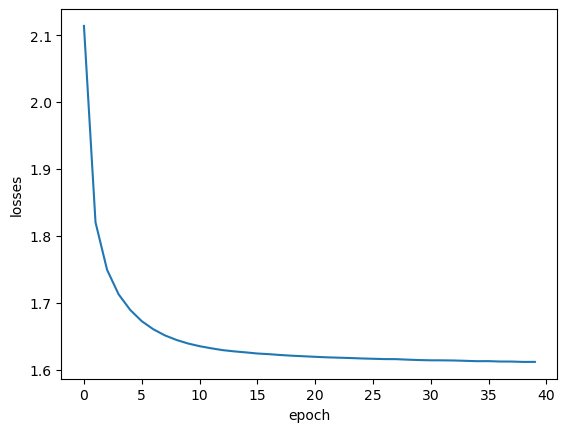

In [223]:
# Your plot code here
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

model = RNN(len(token_to_idx)).to(device)
plt.plot(train(model, TensorDataset(torch.cat(inps_arr), torch.cat(tars_arr)), epochs = 40, learning_rate = 0.001))
plt.xlabel("epoch")
plt.ylabel("losses")
plt.show()

In [224]:
# def generate_sample(char_rnn, seed_phrase=" Hello", max_length=MAX_LENGTH, temperature=1.0):
#     """
#     ### Disclaimer: this is an example function for text generation.
#     ### You can either adapt it in your code or create your own function

#     The function generates text given a phrase of length at least SEQ_LENGTH.
#     :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
#     :param max_length: maximum output length, including seed_phrase
#     :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
#         smaller temperature converges to the single most likely output.

#     Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
#     of the next symbol.
#     """

#     x_sequence = [token_to_id[token] for token in seed_phrase]
#     x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
#     hid_state = char_rnn.initial_state(batch_size=1)

#     # feed the seed phrase, if any
#     for i in range(len(seed_phrase) - 1):
#         print(x_sequence[:, -1].shape, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, i], hid_state)

#     # start generating
#     for _ in range(max_length - len(seed_phrase)):
#         print(x_sequence.shape, x_sequence, hid_state.shape)
#         out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
#         # Be really careful here with the model output
#         p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

#         # sample next token and push it back into x_sequence
#         print(p_next.shape, len(tokens))
#         next_ix = np.random.choice(len(tokens), p=p_next)
#         next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
#         print(x_sequence.shape, next_ix.shape)
#         x_sequence = torch.cat([x_sequence, next_ix], dim=1)

#     return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])





import torch.nn.functional as tnnf
from collections import Counter

def generate_sample(model, token_to_idx, text, size, temperature=1.0):
    model.eval()
    
    with torch.no_grad():
        hid = model.init(1)
        seq = torch.tensor([[token_to_idx.get(char, 0) for char in text]], dtype = torch.int64).to(device)

        for _ in range(size - len(text)):
            out, hid = model(seq, hid)
            
            next_char_index = torch.multinomial(tnnf.softmax(out[:, -1, :] / temperature, dim = -1), num_samples=1)[:, 0].item()
            text += idx_to_token[next_char_index]
            seq = torch.cat((seq[:, 1:], torch.tensor([[next_char_index]], dtype = torch.int64).to(device)), dim = 1)

    return text

def most_popular_words_set(text, amount = 3, l = 2):
    split_it = text.split()
    counters_found = Counter(split_it)
    filtered_dict = {k: v for k, v in counters_found.most_common(amount) if len(k) >= l}
    
    return filtered_dict

In [241]:
# An example of generated text.

print('WORDS REPEATS:')
for temp in range(1, 10, 1):
    gen_text = generate_sample(model, token_to_idx, "мой дядя", 500, temperature = (temp / 10))
    print(most_popular_words_set(gen_text, l = 2))

gen_text = generate_sample(model, token_to_idx, "мой дядя", 500, temperature = 0.2)
print(gen_text)

WORDS REPEATS:
{'не': 5}
{'он': 3, 'где': 2}
{'на': 3, 'но': 3}
{'света': 2}
{'не': 3, 'сердечных': 2}
{'он': 3}
{'мой': 2}
{'не': 3}
{'про': 2}
мой дядя,
где бедной,
слова пора,
когда старины.
о не даной.
как гостей
зимой белоколи
и простительный
из это света
ничто объяныка
мне сумаца
стоял неволе
про долгиа
мне перед,
как будто нежнемя,
когда беду,
татьяна своей.



xxxv

но в санить
опять вызьк молодой,
с ней угрывы
для онегин?



xlvi

но мне своей,
и нынче проски,
о сказала,
как бури стражин,
как он уме?
кончили даной,
и записторном
и молча любовью,
он поставляя,
не знал, он умне,
не понимать?» — так же молчить
им обвиесь.
он верил,


In [226]:
# torch.save(model, 'rnn')

Я проварьировал температуру от 0.1 до 1 с шагом 0.1. Можем заметить, что при меньшей температуре количество слов у которых длина >= 2 (т.е. не предлоги, частицы, местоимения и т.д и т.п.) больше. Можно варьировать параметр l, чтобы выбрать количество наиболее популярных слов с длиной не меньшей l. Я заметил, что практически всегда в конце диапозона повтор слов не превышает двух.

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

In [227]:
# Your beautiful code here
def train1(model, loader, epochs = 10, learning_rate = 0.05):
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    cel = nn.CrossEntropyLoss()

    loss_arr = []

    start = datetime.datetime.now()
    for i in range(epochs):
        full = 0

        for inps, tars in enumerate(loader):
            inps = inps.to(device)
            tars = tars.to(device)

            hidden = model.init_hidden(inps.size(0))
            opt.zero_grad()
            out, _ = model(inps, model.init(inps.size(0)))

            loss = cel(out.reshape(-1, len(token_to_idx)), tars.reshape(-1))
            loss.backward()
            opt.step()
            full += loss.item()

        loss_arr.append(full / len(loader))
        print(i)

    finish = datetime.datetime.now()
    print(f'diff time:{str(finish - start)}')

    return loss_arr

class LSTM(nn.Module):
    def __init__(self, size, emb_size = 64, hid_size = 64*2):
        super().__init__()
        self.embedding = nn.Embedding(size, emb_size)
        self.lstm = nn.LSTM(emb_size, hid_size, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(hid_size, size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(self.embedding(x), hidden)
        return self.linear(out), hidden

    def init(self, size):
        return (torch.zeros(1, size, self.lstm.hidden_size).to(device), torch.zeros(1, size, self.lstm.hidden_size).to(device))

Класс LSTM и функцию train1 я реализовал в точности, как и RNN с функцией train.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
diff time:0:04:53.843887


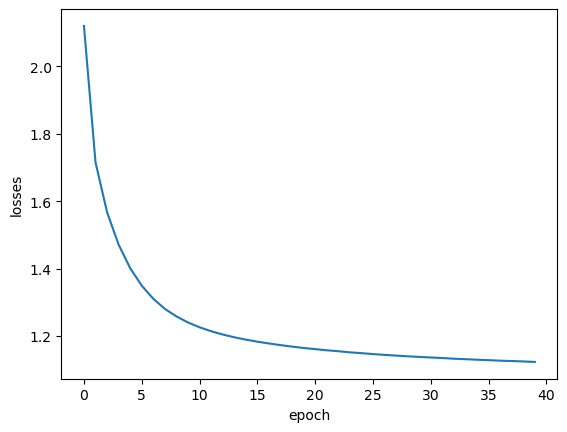

In [228]:
# Text generation with different temperature values here
model = LSTM(len(token_to_idx)).to(device)
plt.plot(train(model, TensorDataset(torch.cat(inps_arr), torch.cat(tars_arr)), epochs = 40, learning_rate = 0.001))
plt.xlabel("epoch")
plt.ylabel("losses")
plt.show()

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [259]:
# Saving and loading code here
print('WORDS REPEATS:')
for temp in range(1, 10, 1):
    gen_text = generate_sample(model, token_to_idx, "мой дядя", 500, temperature = (temp / 10))
    print(most_popular_words_set(gen_text, l = 2))

gen_text = generate_sample(model, token_to_idx, "мой дядя", 500, temperature = 0.2)
print(gen_text)

WORDS REPEATS:
{'не': 5, 'ним': 2}
{'не': 4}
{'на': 4}
{'мой': 2}
{'но': 3}
{'когда': 2}
{'мой': 2}
{'но': 2}
{'он': 3}
мой дядя,
где бедной,
слова полани,
мечтам невгеней.
ничто медведь многи дева
ты знаемый,
но забывший,
неугордость».
прилждетной
умен и нашей
сиянье гонит…
и в сем укжет.



xxv

и там уж о том,
пойде, татьяна?» —
«ну, че, так ль ваш волненье.
но дней хранит
прогулки молодой,
на старый,
и всё рассыла.
ах, то льений
задумавно
на него рожаешь,
там на правостью ее романа,
в сем укжет.



xxv

грамм шумя:
как онегин?



xlii

пойдем души своей.



xxxv

но вот одна
с ним покой
открыты искузамия ей
п


In [230]:
# torch.save(model, 'lstm')

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT